## 3M Data Science Summer Internship 2023: Take-Home Assessment
##### Name: Guilherme de Sousa, PhD Candidate, University of Maryland
##### Contact: gdesousa@umd.edu, https://guidesousa.com

### Problem formulation:
Tyler’s Tubing is an outdoor recreation company that offers equipment rentals for river tubing during the summer months and snow tubing during the winter months. These activities are very seasonal and weather dependent, so the business only operates during certain times of the year. The company currently has rental locations in 10 different cities and is interested in expanding to a new city and adding a new location in 2023. There are three candidate locations being considered, and management needs help selecting one of the three candidates.

Based on the transaction data from the current open locations, weather information from 2019-2022 and demographics of each city, the task is to predict what would have been the profit of each potential new location in the year of 2022.

### Summary of results:
1) The business model is very seasonal with large cash flow during summer and winter months.
2) The operations during the year can be devided in 4 categories: Snow tubing, River Tubing, Off-season snow tubing and Off-season river tubing. During the off-season months, we have lower profit even though the temperature might be ideal for operation.
3) I used a Linear Regression model for each category. Because each operation mode (river/snow & season/off-season) have different characteristic, it is more accurate to have a model for each period.
4) The most promising new location is Loc 13 with a potential revenue of $51,000 year-to-date in 2022.
5) The difference in potential profit among the three locations seems enough to believe this is a resonable decision and errors from the analysis are expected to be smaller than the difference between the most profitable and the second most profitable potential location.

### Assumptions & limitations:
- I focused on total profit by suming over all transactions for each day.
- Analysis depends on the time window of the time series.
- I considered the snow tubing service to happen when temperature < 40F & river tubing when temperature > 40F. And I counted snowing as precipitation.
- Simplistic or no outlier removal in the data set. 

### Future work:
- Apply more sophisticated methods for clustering to handle outliers.
- A careful study on the average number of customers for each location could help the company to expand the renting options and services.
- More complex models might revel hidden features of the data that I wasn't able to draw in this preliminary study.

Imported packaged. Using Python 3.8.8

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

Auxiliary functions to normalize, categorize and predict data of the dataframes.

In [2]:
# Auxiliary functions
def normalize(df, cols=None, norm='mean'):
    result = df.copy()
    if not cols:
        cols = df.columns
    for c in cols:
        if norm == 'mean':
            mean_value = df[c].mean()
            std_value = df[c].std()
            result[c] = (df[c] - mean_value) / std_value
        if norm == 'minmax':
            min_value = df[c].min()
            max_value = df[c].max()
            result[c] = (df[c] - min_value) / (max_value - min_value)
    return result

def is_off_season(week):
    return ((week > 8) & (week < 22)) or ((week > 36) & (week < 48))

def profit_predict_model(models,row,vars):
    m = models[row[vars[0]]]
    return m.intercept_[0] + np.sum(m.coef_[0]*np.array([row[v] for v in vars[1:]]))

Load files, data clean-up and basic normalization routines to standardize the dataframes.

In [3]:
from os import listdir, getcwd

##############
# Load files #
##############
# PATH
PATH = getcwd() + '/data/'
files = listdir(PATH)

# Location, Holiday and Weather dataframes
df_location = pd.read_csv(PATH+'location_data.csv')
df_holiday = pd.read_csv(PATH+'holiday_data.csv')
df_weather = pd.read_csv(PATH+'weather_data.csv').astype({'date':'datetime64[ns]'})
df_weather['rent'] = df_weather['temperature'].apply(lambda x: 'snow' if x < 40 else 'river')
df_weather['dayofyear'] = df_weather['date'].dt.dayofyear
df_weather['weekofyear'] = df_weather['date'].dt.isocalendar().week
df_weather['month'] = df_weather['date'].dt.month
df_weather['year'] = df_weather['date'].dt.year
df_weather['season'] = df_weather['weekofyear'].apply(lambda x: 0 if is_off_season(x) else 1).astype('int')

# Transactions dataframe
df_transaction = []
for file in files:
    if ('system1' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0))
    if ('system2' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0, sep='\t'))
    if ('system3' in file):
        with open(PATH + file) as f:
            data = json.loads(f.read())
            df_transaction.append(pd.json_normalize(data))
df_transaction = pd.concat(df_transaction)
# Remove $ symbol in System 1
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: str(x).split('$')[1] if '$' in str(x) else x)
# Fix negative values of System 2 that writes '0-x' for negative values
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: '-'+str(x).split('-')[1] if '-' in str(x) else x)
# Change column datatypes for a standard format
df_transaction = df_transaction.astype({'location_id':int, 'date':'datetime64[ns]', 'transaction_id':int, 'profit':float})

# Dataframe for daily profit + location information
# Map 'cloudy' and 'precipitation' boolean into 0/1
# DropNA() for use in the modelling
df_profit = df_transaction.groupby([df_transaction['location_id'],df_transaction['date']])[['profit']].agg('sum')
df_profit = pd.merge(df_profit, df_weather, how='left', left_on=['location_id','date'], right_on=['location_id','date'])
df_profit = pd.merge(df_profit, df_location, how='left', left_on=['location_id'], right_on=['location_id'])
df_profit['cloudy'] = df_profit['cloudy'].replace({True: 1, False: 0})
df_profit['precipitation'] = df_profit['precipitation'].replace({True: 1, False: 0})
df_profit = df_profit.dropna()
df_profit = df_profit[df_profit['weekofyear'] != 53] # remove the last week because it contains less than 7 days
weeks_of_operation = df_profit['weekofyear'].unique().to_numpy()

# Normalize dataframes & groupby time window
df_profit_norm_daily = df_profit.copy()
df_profit_norm_daily = df_profit_norm_daily.dropna()
df_profit_norm_daily = df_profit_norm_daily.groupby(['location_id','dayofyear','year'], as_index=False).\
    agg({'profit':'sum','dayofyear':'mean','temperature':'mean','pressure':'mean','cloudy':'mean',
    'precipitation':'mean','humidity':'mean','population':'mean','elevation':'max','season':'mean'}).\
        groupby(['location_id','dayofyear'], as_index=False).agg('mean')
df_profit_norm_daily['rent'] = df_profit_norm_daily['temperature'].apply(lambda x: 'snow' if x < 40 else 'river')
df_profit_norm_daily['rent_season'] = \
    df_profit_norm_daily[['temperature','season']].apply(lambda x: 'snow' if (x['temperature'] < 40) & (round(x['season']) == 1) else \
        ('snow_off' if (x['temperature'] < 40) & (round(x['season']) == 0) else \
        ('river' if (x['temperature'] > 40) & (round(x['season']) == 1) else 'river_off')), axis=1)
df_profit_norm_daily = normalize(df_profit_norm_daily, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_weekly = df_profit.copy()
df_profit_norm_weekly = df_profit_norm_weekly.dropna()
df_profit_norm_weekly = df_profit_norm_weekly.groupby(['location_id','weekofyear','year'], as_index=False).\
    agg({'profit':'sum','weekofyear':'mean','temperature':'mean','pressure':'mean','cloudy':'mean',
    'precipitation':'mean','humidity':'mean','population':'mean','elevation':'mean','season':'mean'}).\
        groupby(['location_id','weekofyear'], as_index=False).agg('mean')
df_profit_norm_weekly['rent'] = df_profit_norm_weekly['temperature'].apply(lambda x: 'snow' if x < 40 else 'river')
df_profit_norm_weekly['rent_season'] = \
    df_profit_norm_weekly[['temperature','season']].apply(lambda x: 'snow' if (x['temperature'] < 40) & (round(x['season']) == 1) else \
        ('snow_off' if (x['temperature'] < 40) & (round(x['season']) == 0) else \
        ('river' if (x['temperature'] > 40) & (round(x['season']) == 1) else 'river_off')), axis=1)
df_profit_norm_weekly = normalize(df_profit_norm_weekly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_monthly = df_profit.copy()
df_profit_norm_monthly = df_profit_norm_monthly.dropna()
df_profit_norm_monthly = df_profit_norm_monthly.groupby(['location_id','month','year'], as_index=False).\
    agg({'profit':'sum','month':'mean','temperature':'mean','pressure':'mean','cloudy':'mean',
    'precipitation':'mean','humidity':'mean','population':'mean','elevation':'max','season':'mean'}).\
        groupby(['location_id','month']).agg('mean')
df_profit_norm_monthly['rent'] = df_profit_norm_monthly['temperature'].apply(lambda x: 'snow' if x < 40 else 'river')
df_profit_norm_monthly['rent_season'] = \
    df_profit_norm_monthly[['temperature','season']].apply(lambda x: 'snow' if (x['temperature'] < 40) & (round(x['season']) == 1) else \
        ('snow_off' if (x['temperature'] < 40) & (round(x['season']) == 0) else \
        ('river' if (x['temperature'] > 40) & (round(x['season']) == 1) else 'river_off')), axis=1)
df_profit_norm_monthly = normalize(df_profit_norm_monthly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

# Sample values
df_profit.sample(10)

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,rent,dayofyear,weekofyear,month,year,season,population,elevation
6448,9,2020-07-14,206.78,75.74,1033.497653,0.96,0.0,0.0,river,196.0,29,7.0,2020.0,1.0,13641,350
64,1,2019-06-01,228.36,72.50,960.798122,0.84,1.0,1.0,river,152.0,22,6.0,2019.0,1.0,18428,375
5774,8,2021-01-05,354.50,17.96,996.255869,0.62,1.0,1.0,snow,5.0,1,1.0,2021.0,1.0,52185,398
2181,3,2022-06-02,350.39,61.88,1031.713615,0.94,1.0,0.0,river,153.0,22,6.0,2022.0,1.0,74138,505
6094,8,2022-07-30,381.86,66.20,1008.744131,0.84,0.0,0.0,river,211.0,30,7.0,2022.0,1.0,52185,398
3424,5,2020-12-15,209.70,14.36,1019.002347,0.39,0.0,0.0,snow,350.0,51,12.0,2020.0,1.0,12686,386
3591,5,2021-08-31,244.79,45.86,1041.302817,0.63,0.0,0.0,river,243.0,35,8.0,2021.0,1.0,12686,386
6859,9,2022-08-05,356.55,76.82,1023.685446,0.91,0.0,0.0,river,217.0,31,8.0,2022.0,1.0,13641,350
3468,5,2021-01-30,287.66,12.02,993.356808,0.00,1.0,0.0,snow,30.0,4,1.0,2021.0,1.0,12686,386
4590,7,2019-01-14,169.00,11.12,1048.884977,0.64,0.0,0.0,snow,14.0,3,1.0,2019.0,1.0,13400,186


The profit ir very seasonal as expected. The most profitable months of operation are the summer (with river tubing) and winter (snow tubing). Here it is possible to see that choosing a weekly time window we can get the most information from the plot without too much noise.

The yearly profit can vary substantially. The yearly business' profit is smaller compared to the pre-pandemic levels.

<AxesSubplot:xlabel='year', ylabel='profit'>

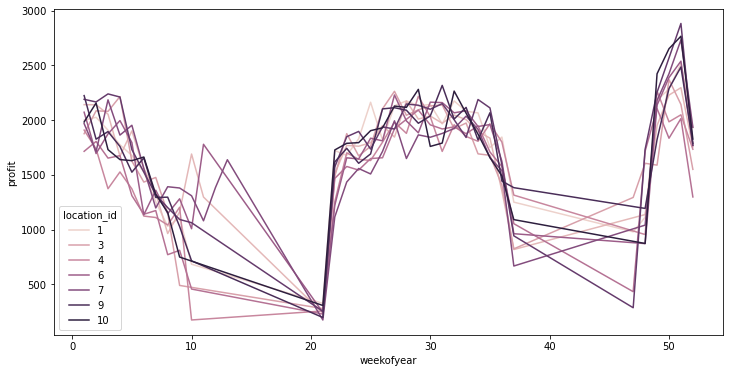

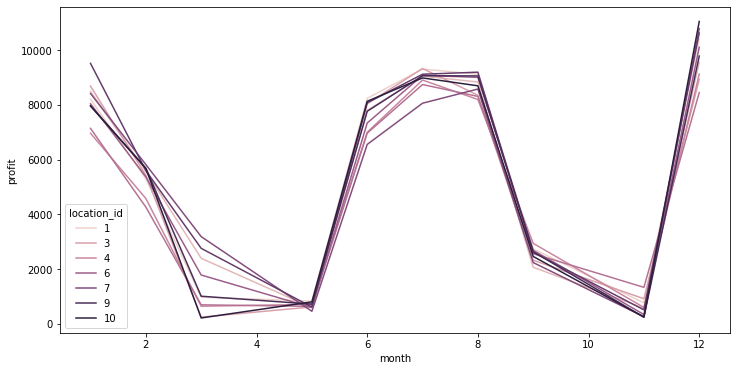

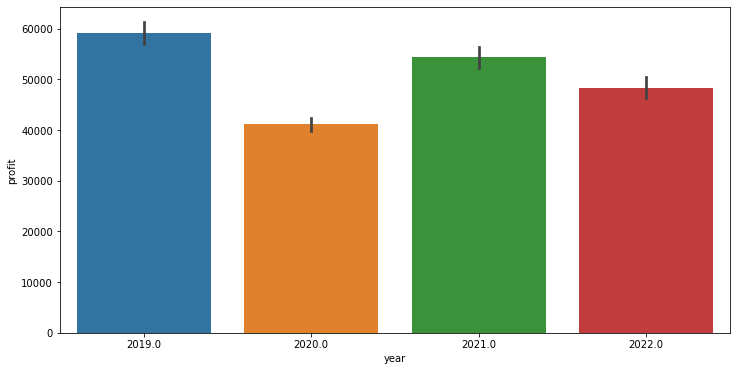

In [4]:
# Rental Profit Variation
# We have cyclic pattern - Large profits during winter with snow tubing and during summer with river tubing
# This result indicates we should include the time dependence into account for modelling the profit for each location
df = df_profit
plt.figure(figsize=(12,6))
sns.lineplot(data=df.groupby([df['location_id'],df['weekofyear'],df['year']],as_index=False).agg({'profit':'sum'}).\
    groupby(['location_id','weekofyear'],as_index=False).agg({'profit':'mean'}), x='weekofyear', y='profit', hue='location_id')

plt.figure(figsize=(12,6))
sns.lineplot(data=df.groupby([df['location_id'],df['month'],df['year']],as_index=False).agg({'profit':'sum'}).\
    groupby(['location_id','month'],as_index=False).agg({'profit':'mean'}), x='month', y='profit', hue='location_id')

# Yearly dependence of the profits
# Probably because of the disruptions caused by the pandemic we should be carefull to compare year to year
df = df_profit
plt.figure(figsize=(12,6))
sns.barplot(data=df.groupby(['year', 'location_id'], as_index=False).agg({'profit':'sum'}), x='year', y='profit')

The correlation between profit and the other variables changes as we choose different time windows. The daily profit is very much noisy with a clear distinction as a function of temperature. The weekly profit shows the effects of the off-season months. The montly time window is very similar to the weekly one with less data points.

From this point, I focused my analysis in the weekly time frame.

Text(0.5, 1.08, 'Monthly distribution')

<Figure size 576x432 with 0 Axes>

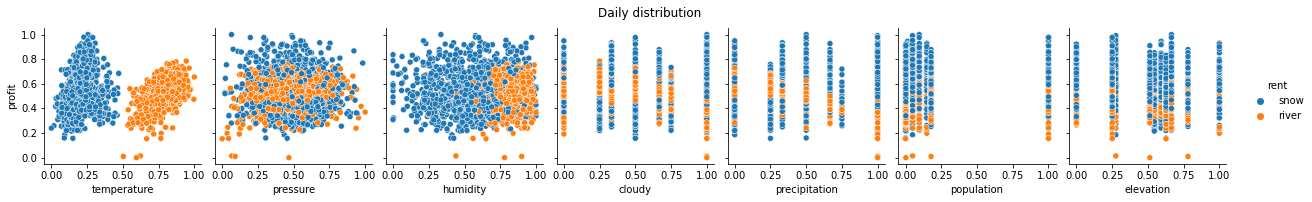

<Figure size 576x432 with 0 Axes>

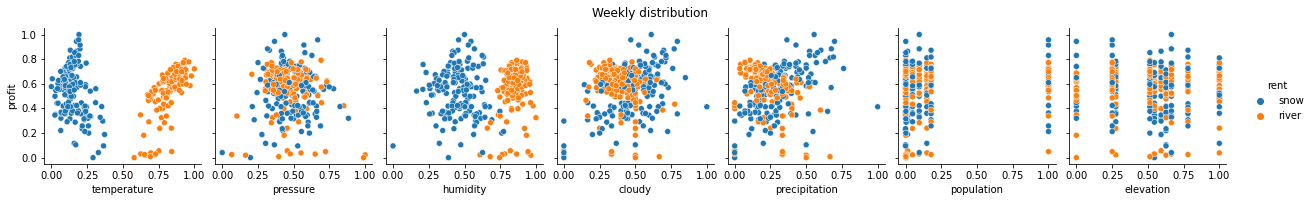

<Figure size 576x432 with 0 Axes>

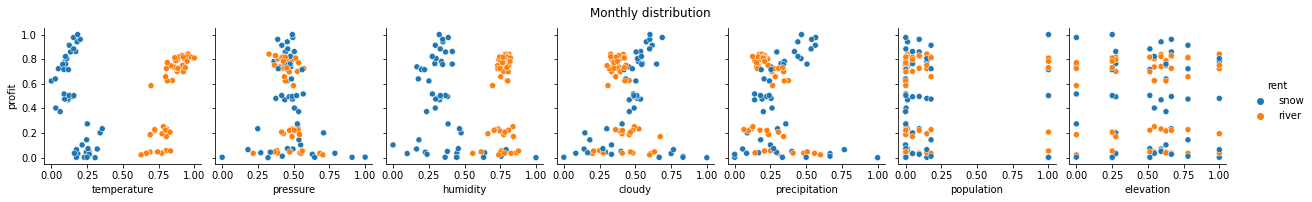

In [5]:
# Here I plotted the datapoints of profit as a function of the other parameters for three different time windows
# Dt = {daily, weekly, monthly}
# Visually, the weekly time frame seems to capture the correlation with less noise
df = df_profit_norm_daily
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent', kind='scatter')
s.fig.suptitle('Daily distribution', y=1.08)

df = df_profit_norm_weekly
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent', kind='scatter')
s.fig.suptitle('Weekly distribution', y=1.08)

df = df_profit_norm_monthly
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='rent', kind='scatter')
s.fig.suptitle('Monthly distribution', y=1.08)

Now that I identified the optimal time window (weekly) for this analysis we can ask how much the data depends on the season/off-season cycles. Clearly, the off-season months has a different dynamics of operation, we could for example cut costs of operation by correctly identifying the off-season periods.

Text(0.5, 1.08, 'Weekly distribution')

<Figure size 576x432 with 0 Axes>

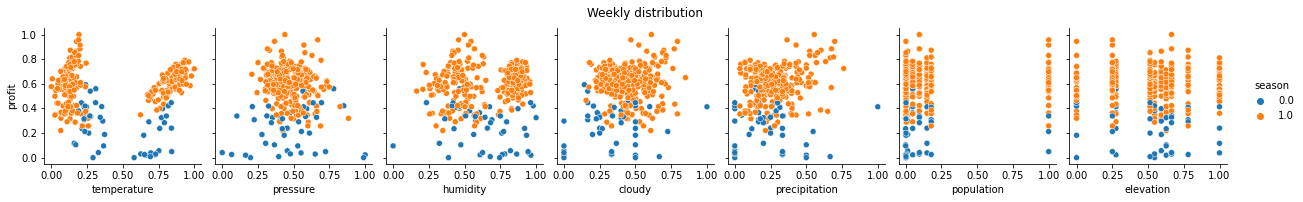

In [6]:
# Season/Off-Season distributions
df = df_profit_norm_weekly
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='season', kind='scatter')
s.fig.suptitle('Weekly distribution', y=1.08)

Using a clustering algorithm (K-Means & the Elbow method) the analysis more or less identified the off-season operation. I added by hand the distinction of snow/river tubing into the off-season cluster. Now we are left with 4 clusters. From now I'll use the river/snow tubing and season/off-season distinctions for simplicity.

c:\Users\guilh\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


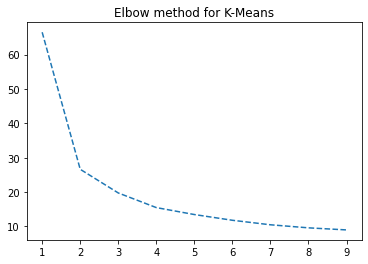

<Figure size 576x432 with 0 Axes>

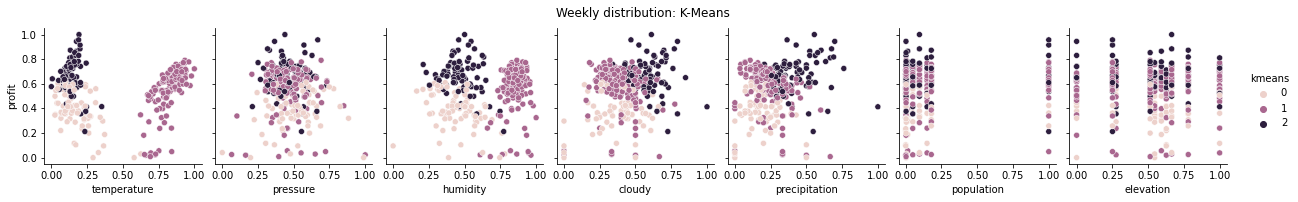

In [8]:
# K-Means clustering to identify commom regimes of business operations
# Elbow method for optimal number of clusters
from sklearn.cluster import KMeans

# Data
df = df_profit_norm_weekly.copy()
#df = df_profit_norm_monthly.copy()
#df = df_profit_norm.drop(['date'],axis=1).copy()

K = range(1,10)
kmeans_cols = ['profit','temperature','precipitation','cloudy']
kmeans_score = np.zeros(len(K))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df[kmeans_cols])
    kmeans_score[k-1] = kmeanModel.inertia_
s = sns.lineplot(x=K, y=kmeans_score, linestyle='--')
s.set_title('Elbow method for K-Means')

# Choosing K-means with 3 clusters
K = 3
kmeanModel = KMeans(n_clusters=K)
kmeanModel.fit(df[kmeans_cols])
df_profit_norm_kmeans = df_profit_norm_weekly.copy()
df_profit_norm_kmeans['kmeans'] = pd.Series(kmeanModel.labels_)

# Plot dataframe clustered by K-Means
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_kmeans, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation'], 
    y_vars='profit', hue='kmeans')
s.fig.suptitle('Weekly distribution: K-Means', y=1.08)

# Add a new K-Means cluster to differentiate snow and river tubing
kmeans_keys = df_profit_norm_kmeans.groupby('kmeans').agg({'temperature':'max'}).to_dict()['temperature']
river_cluster = max(kmeans_keys, key=kmeans_keys.get)
snow_cluster = min(kmeans_keys, key=kmeans_keys.get)
keys = [0,1,2]
keys.remove(snow_cluster)
keys.remove(river_cluster)
off_season_cluster = keys[0]

Correlation between the Profit and the other variables for each regime of operation (four clusters). We see that the most importatnt variables are Temperature, Cloudy, Precipitation and Humidity.

Text(0.5, 1.0, 'Profit correlation - Weekly window')

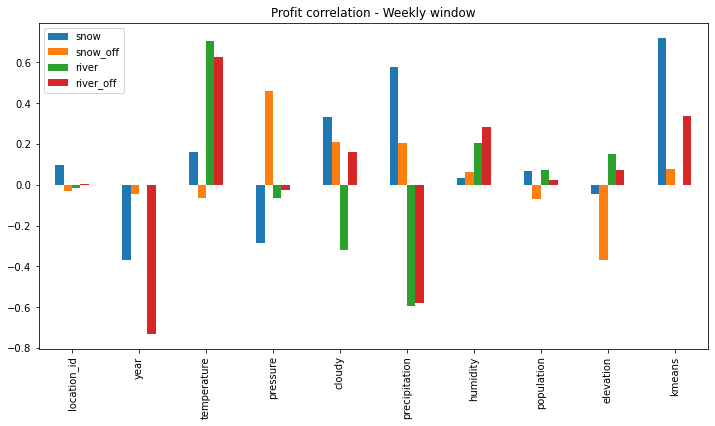

In [9]:
# Profit correlation to the other variables
df_cor = pd.DataFrame()
for label in ['snow', 'snow_off', 'river', 'river_off']:
    df_cor[label] = df_profit_norm_kmeans[df_profit_norm_kmeans['rent_season']==label].drop(['weekofyear','season'],axis=1).corr()['profit'].drop('profit')
df_cor.plot.bar(figsize=(12, 6))
#df_nor[df_nor['rent']=='river'].corr()['profit'].drop('profit').plot.bar()
plt.title('Profit correlation - Weekly window')

Based on those four clusters (regimes of operation) I run a Linear Regression model to predict the profit in terms of the other variables. Based on the correlation matrix, I choose Temperature, Precipitation, Cloudy, Humidity and Elevation. The red line is the fitted line, it seems a little off for some of the cluster but that is simply because it is a line in a 5D space (hyperplane) but I choose to plot it based only in one of the parameters (Temperature).

0.48457139955359274
-0.40260707781254523
0.7436446395819003
0.7689800329986964


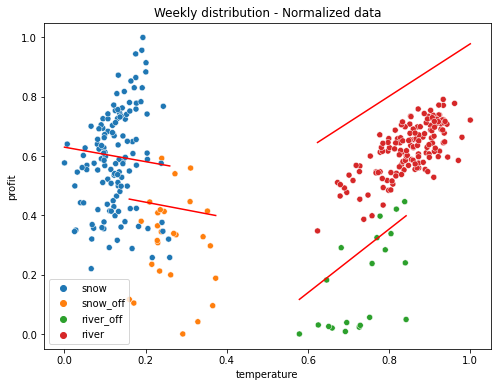

In [10]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Remove outliners
df = df_profit_norm_kmeans.copy()
#df['rent_season'] = df[['rent_season', 'profit', 'temperature']].apply(lambda x: 'snow_off' if (x['profit'] < 0.6) & (x['rent_season'] == 'snow') 
#    else x['rent_season'], axis=1)
#df['rent_season'] = df[['rent_season', 'profit', 'temperature']].apply(lambda x: 'river' if (x['temperature'] > 0.4) & (x['rent_season'] == 'river_off') 
#    else x['rent_season'], axis=1)
#df['rent_season'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'outliers' if (x['profit'] < 0.2) & (x['temperature'] < 0.2) & (x['rent'] == 'snow_off') 
#   else x['rent'], axis=1)
#df['rent_season'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'outliers' if (x['profit'] < 0.4) & (x['rent'] == 'snow') 
#   else x['rent'], axis=1)

# Plot dataframe distribution
plt.figure(figsize=(8,6))
s = sns.scatterplot(data=df[df['rent_season'] != 'outliers'], x='temperature', y='profit', hue='rent_season')
s.set_title('Weekly distribution - Normalized data')

# Train-Test data
# Season dependent model
# River tubing and Snow tubing
model_rent = {}
model_vars = ['temperature','precipitation','cloudy','humidity','elevation']
for label in ['snow', 'snow_off', 'river', 'river_off']:
    x = df.loc[df['rent_season']==label,model_vars].to_numpy()
    y = df.loc[df['rent_season']==label,'profit'].to_numpy()
    y = y.reshape(-1, 1)

    # Linear model training
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

    # Model Fit + Prediction
    model_rent[label] = LinearRegression()
    model_rent[label].fit(xtrain, ytrain)
    ypred = model_rent[label].predict(xtest)
    ypred = ypred.reshape(1,-1)[0]
    print(model_rent[label].score(xtest,ytest))

    # Plotting linear regression
    line_x = np.linspace(x[:,0].min(), x[:,0].max(), 100)
    line_y = model_rent[label].intercept_[0] + model_rent[label].coef_[0][0]*line_x
    sns.lineplot(x=line_x, y=line_y, linestyle='-', color='red')

Here is the final prediction step for the profit in each of the four seasons. The time series of each location is roughly similar and they have the same features of the real historical data, the predictions and the model seems enough to capture the importante features among the variables.

As we can see from the final plot, Location = 13 would have the largest profit among the three places if it was open in 2022. The relative difference in profits are larger than the expected erros so I believe the results are reliable.

The final plot shows the comparison of the average profit of Locations 1-10 from Jan 1 to Oct 31 and the expected profit of Locations 11-13 for the same period of 2022.

Location 11 revenue in 2022 (Jan 1 - Oct 30): 46932.824010852564
Location 12 revenue in 2022 (Jan 1 - Oct 30): 43770.43352185027
Location 13 revenue in 2022 (Jan 1 - Oct 30): 51023.23452231846


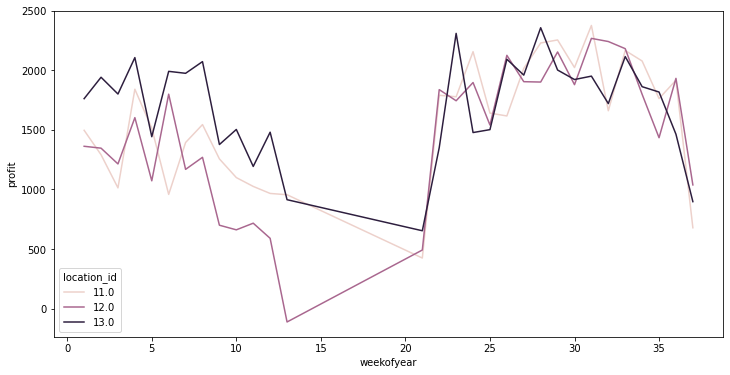

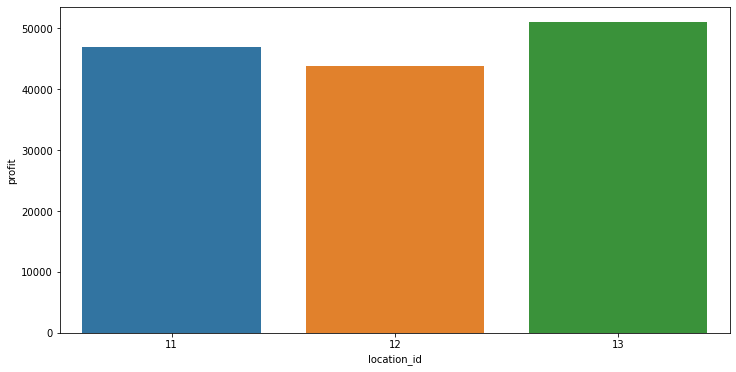

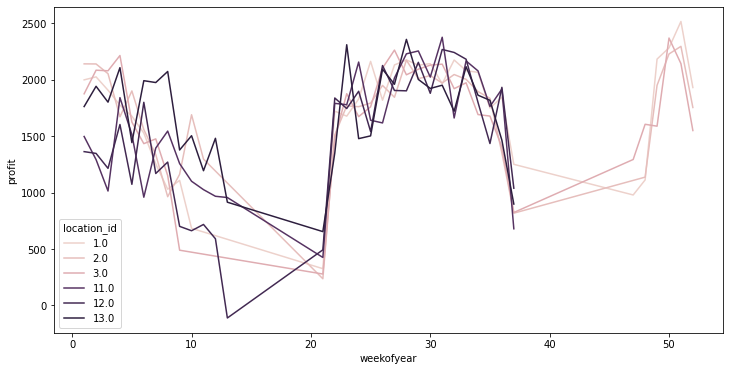

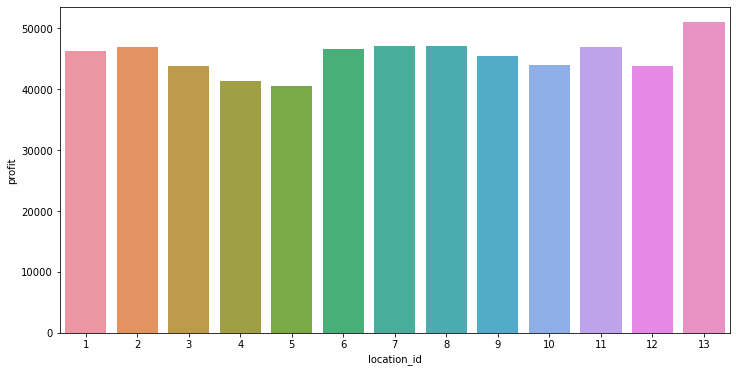

In [11]:
# Location prediction
# Predict profit for new locations
# Model for Snow Season is simply a random variable
m = model_rent

# Cluster by River/Snow and Season/Off-Season
new_loc = [11,12,13]
df_profit_new_loc_weekly = df_weather[(df_weather['location_id'].isin(new_loc)) & (df_weather['weekofyear'].isin(weeks_of_operation))].copy()
df_profit_new_loc_weekly = pd.merge(df_profit_new_loc_weekly, df_location, how='left', left_on=['location_id'], right_on=['location_id'])
df_profit_new_loc_weekly = df_profit_new_loc_weekly[df_profit_new_loc_weekly['weekofyear'] < 52] # Sometimes the first days of the year are labelled as week 52 or 53
df_profit_new_loc_weekly = df_profit_new_loc_weekly[(df_profit_new_loc_weekly['location_id'].isin(new_loc)) & (df_profit_new_loc_weekly['date'].dt.year == 2022)]
df_profit_new_loc_weekly = df_profit_new_loc_weekly.groupby([df_profit_new_loc_weekly['location_id'], df_profit_new_loc_weekly['weekofyear']], 
    as_index=False).agg('mean')
df_profit_new_loc_weekly['rent_season'] = \
    df_profit_new_loc_weekly[['temperature','season']].apply(lambda x: 'snow' if (x['temperature'] < 40) & (x['season'] == 1) else \
        ('snow_off' if (x['temperature'] < 40) & (x['season'] == 0) else \
        ('river' if (x['temperature'] > 40) & (x['season'] == 1) else 'river_off')), axis=1)
df_profit_new_loc_weekly = normalize(df=df_profit_new_loc_weekly, cols=['temperature','pressure','humidity','elevation','population'],norm='minmax')

# Predict values based on Linear Regression & Convert back after renormalization
df_aux = df_profit.groupby(['weekofyear','location_id','year'], as_index=False).agg({'profit':'sum'}).groupby(['weekofyear','location_id'],as_index=False).agg({'profit':'mean'})
df_profit_new_loc_weekly['profit_norm'] = df_profit_new_loc_weekly[['rent_season']+model_vars].\
    apply(lambda x: profit_predict_model(m,x,['rent_season']+model_vars), axis=1)
df_profit_new_loc_weekly['profit'] = df_profit_new_loc_weekly['profit_norm'].apply(lambda x: x * (df_aux['profit'].max()-df_aux['profit'].min()) + df_aux['profit'].min())

# Final dataset all locations
df_all_loc_weekly_profit = pd.concat([df_aux, df_profit_new_loc_weekly[['location_id','weekofyear','profit']]], axis=0)

# Plotting results for potential locations
plt.figure(figsize=(12,6))
sns.lineplot(data=df_profit_new_loc_weekly[['location_id','weekofyear','profit']].astype('float64'), x='weekofyear', y='profit', hue='location_id')

plt.figure(figsize=(12,6))
sns.barplot(data=df_profit_new_loc_weekly.groupby('location_id', as_index=False).agg({'profit':'sum'}), x='location_id', y='profit')

# Plotting results for all locations
plt.figure(figsize=(12,6))
sns.lineplot(data=df_all_loc_weekly_profit.loc[df_all_loc_weekly_profit['location_id'].isin([1,2,3,11,12,13])].astype('float64'), x='weekofyear', y='profit', hue='location_id')

plt.figure(figsize=(12,6))
sns.barplot(data=df_all_loc_weekly_profit[(df_all_loc_weekly_profit['weekofyear'] < 40)].groupby('location_id', as_index=False).agg({'profit':'sum'}), x='location_id', y='profit')

# Results
for loc in new_loc:
    print('Location',loc,'revenue in 2022 (Jan 1 - Oct 30):',
        df_profit_new_loc_weekly[df_profit_new_loc_weekly['location_id']==loc]['profit'].sum())